# Implementation of SIF abstraction rules

protein-centered view

#### Import librairies

In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON, CSV, TURTLE, XML
import IPython
import subprocess
import time
import os
import glob
from requests.utils import requote_uri
from urllib.parse import quote
import re
import pandas as pd
from rdflib import Graph

#### Define the URL of the local SPARQL endpoint and path to BioPAX files

In [ ]:
endpoint_test_example_reactome = "http://localhost:3030/#/dataset/reactome_tgf_smads/query"
rdfFormat = "turtle"
current_directory = os.getcwd()
BioPAX_Ontology_file_path = os.path.join(current_directory, '../', 'TestExampleData', 'biopax-level3.owl')
reactome_test_example = os.path.join(current_directory, '../', 'TestExampleData', 'R-HSA-2173789_level3.owl')

#### Define RDF prefixes for SPARQL queries

In [ ]:
reactomeVersion = 90
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>
PREFIX oboInOwl: <http://www.geneontology.org/formats/oboInOwl#>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX abstraction: <http://abstraction/#>

PREFIX reactome: <http://www.reactome.org/biopax/{}/48887#>
""".format(reactomeVersion)

biopaxURI = "http://www.biopax.org/release/biopax-level3.owl#"

#### Function to display the results of SPARQL queries

In [ ]:
def displaySparqlResults(results):
    '''
    Displays as HTML the result of a SPARQLWrapper query in a Jupyter notebook.
    
        Parameters:
            results (dictionnary): the result of a call to SPARQLWrapper.query().convert()
    '''
    variableNames = results['head']['vars']
    tableCode = '<table><tr><th>{}</th></tr><tr>{}</tr></table>'.format('</th><th>'.join(variableNames), '</tr><tr>'.join('<td>{}</td>'.format('</td><td>'.join([row[vName]['value'] if vName in row.keys() else "&nbsp;" for vName in variableNames]))for row in results["results"]["bindings"]))
    IPython.display.display(IPython.display.HTML(tableCode))

## SIF rules 

BioPAX pathway toy example: TGF-beta receptor signaling activates SMADs (R-HSA-2173789.3)

### In Same Component

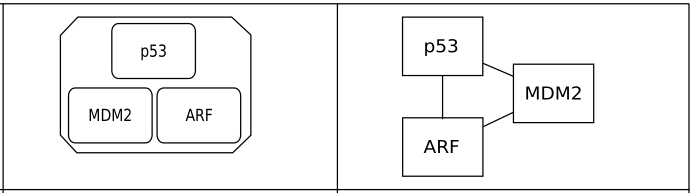

In [ ]:
query_in_same_component = """ 
CONSTRUCT {
  ?component1 abstraction:inSameComponent ?component2 .
}
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?component1 .
  ?complex bp3:component ?component2 .
  
  FILTER(?component1 != ?component2)
  FILTER NOT EXISTS { ?component1 rdf:type bp3:Complex }
  FILTER NOT EXISTS { ?component2 rdf:type bp3:Complex }
}
"""

output graph: protein interactions, some cliques, some sequential interactions

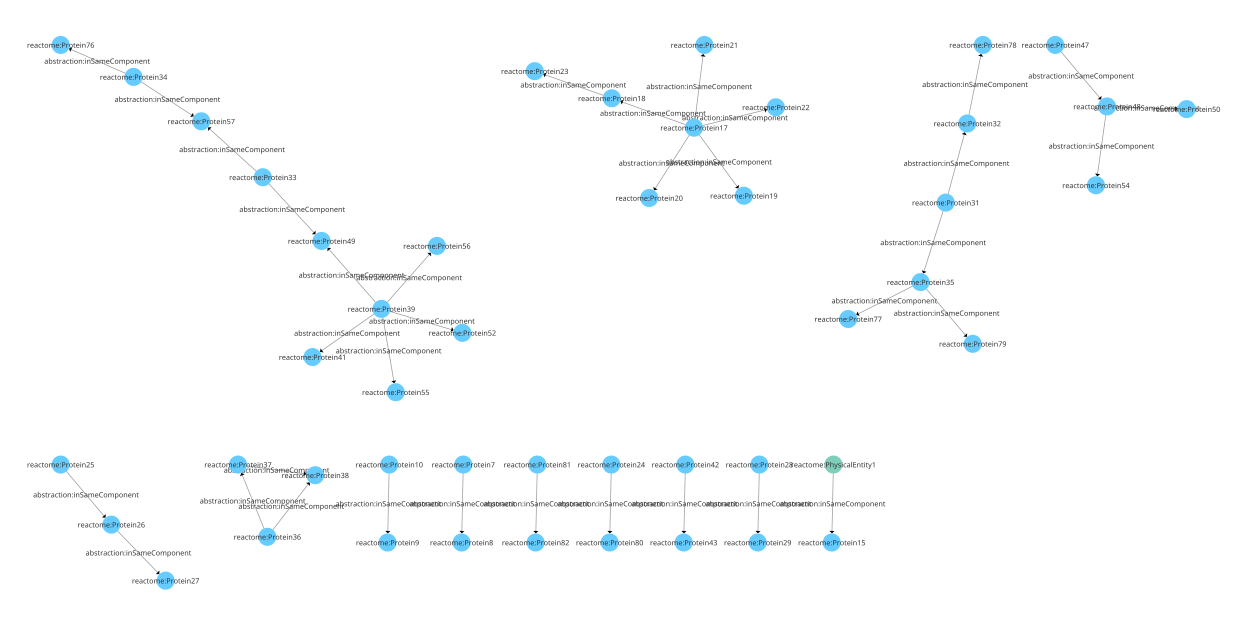

### Component Of

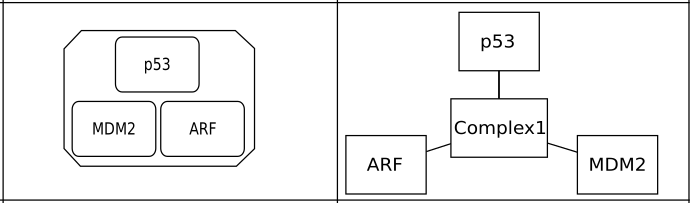

We filter out recursive complexes

In [ ]:
query_component_of = """
CONSTRUCT {
  ?component abstraction:componentOf ?complex .
}
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?component .
  
  # Exclude ?component1 if it is of type bp3:Complex
  FILTER NOT EXISTS { ?component rdf:type bp3:Complex }
}
"""

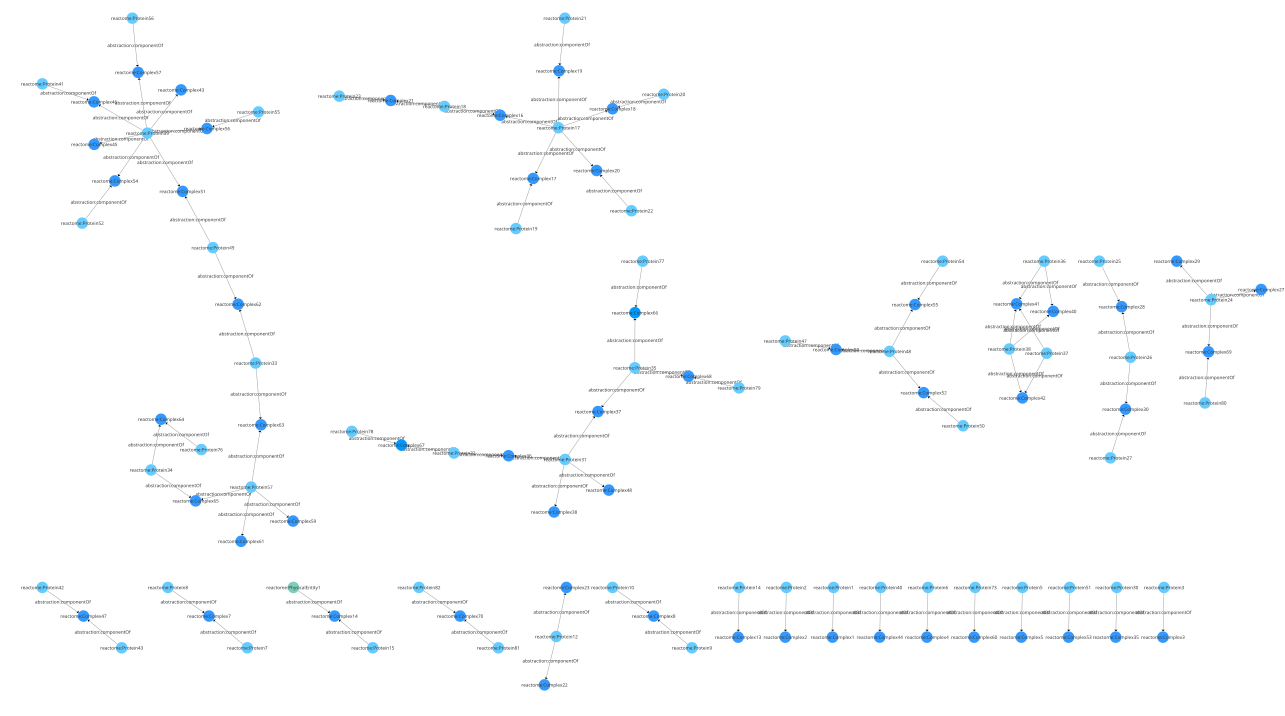

### State Change

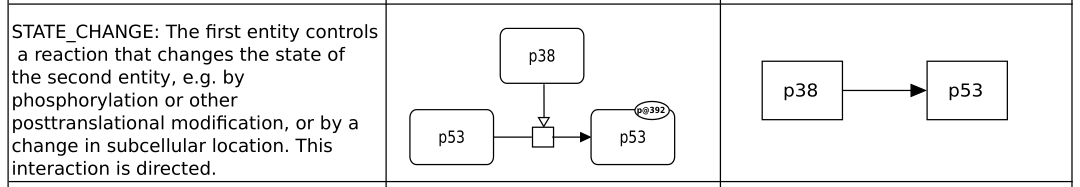

TO COMPLETE

In [ ]:
query_state_change = """
CONSTRUCT {
  ?left abstraction:stateChange ?right .
}
WHERE {
  ?control bp3:controlled ?reaction .
  ?control bp3:controller ?controllingEntity .
  ?reaction rdf:type bp3:BiochemicalReaction .
  ?reaction bp3:left ?left .
  ?reaction bp3:right ?right .
}
"""

# TO DO: trouver comment BioPAX exprime les changements d'états de protéines pour corriger la requête

### Metabolic Catalysis

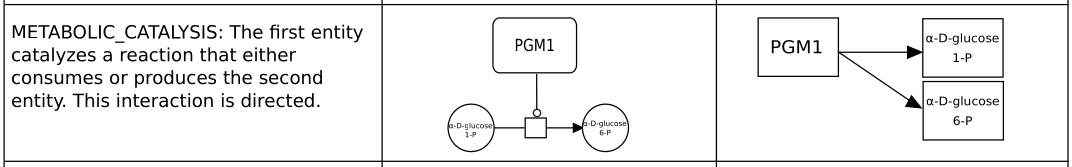

In [ ]:
query_metabolic_catalysis = """
CONSTRUCT {
  ?control abstraction:metabolicCatalysis ?left .
  ?control abstraction:metabolicCatalysis ?right .
}
WHERE {
  ?control bp3:controlled ?reaction .
  ?control bp3:controller ?controllingEntity .
  ?reaction rdf:type bp3:BiochemicalReaction .
  ?reaction bp3:left ?left .
  ?reaction bp3:right ?right .
}
"""

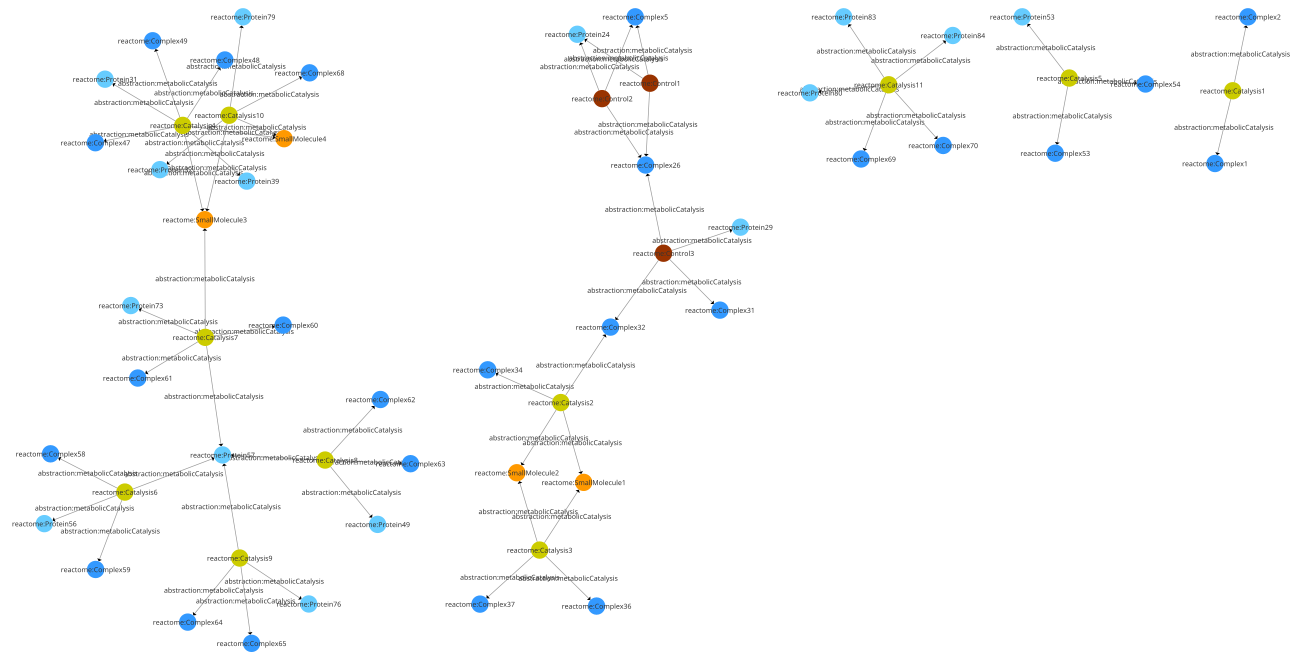

### Reacts With

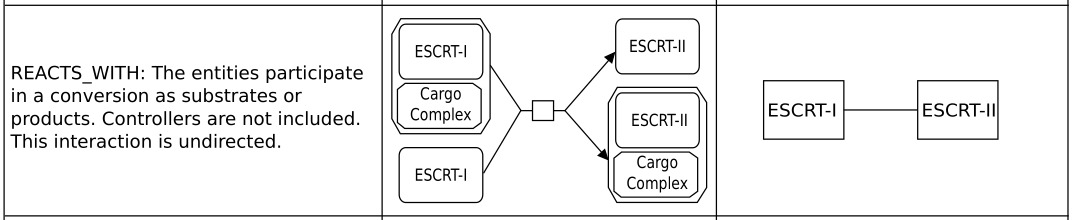

In [ ]:
query_reacts_with = """ 
CONSTRUCT {
  ?left abstraction:reactsWith ?right .
}
WHERE {
  ?interaction rdf:type/(rdfs:subClassOf*) bp3:Interaction .
  ?interaction bp3:left ?left .
  ?interaction bp3:right ?right .
}
"""

undirected interactions 

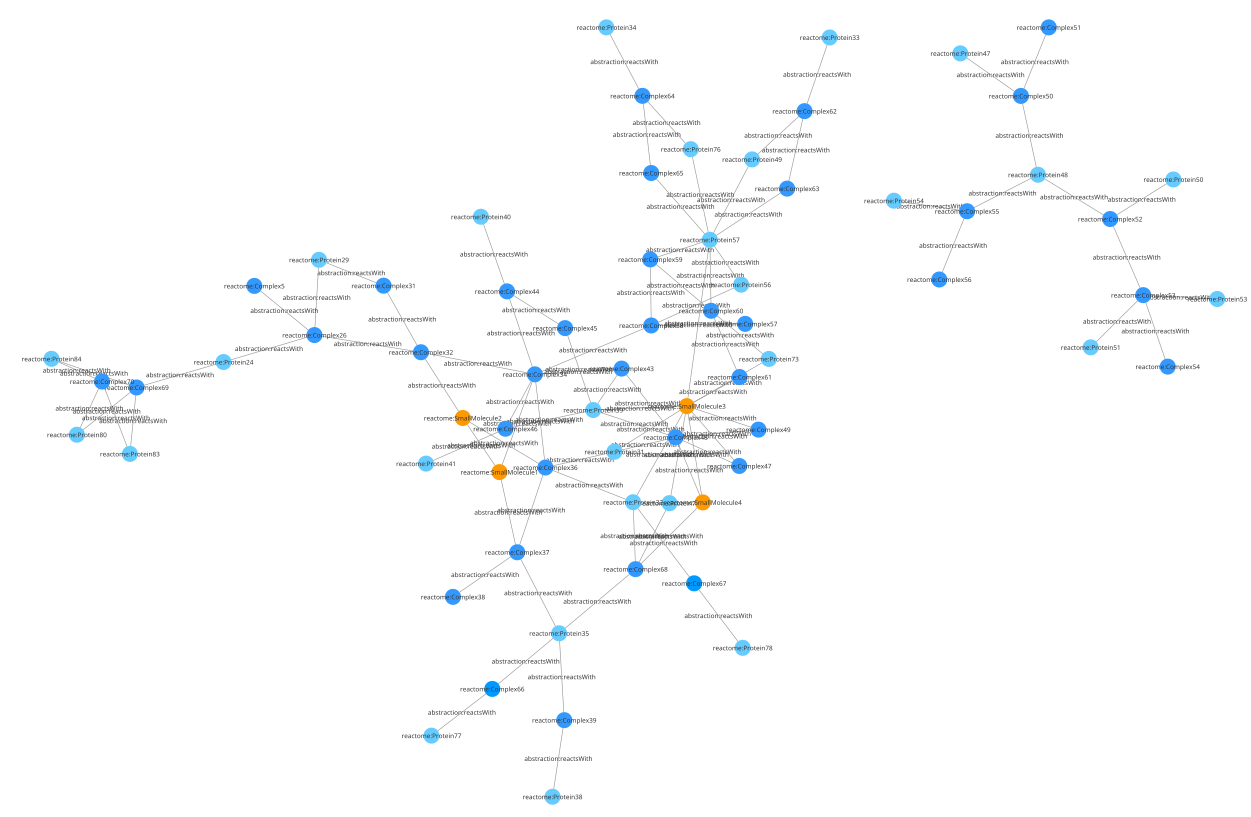

### Sequential Catalysis

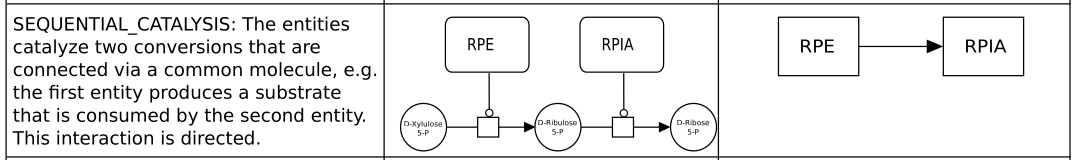

In [ ]:
query_sequential_catalysis = """ 
CONSTRUCT {
  ?control1 abstraction:sequentialCatalysis ?control2 .
}
WHERE {
  ?control1 bp3:controlled ?reaction1 .
  ?control1 bp3:controller ?controllingEntity1 .
  ?reaction1 rdf:type bp3:BiochemicalReaction .
  ?reaction1 bp3:left ?left1 .
  ?reaction1 bp3:right ?right1 .
  
  ?control2 bp3:controlled ?reaction2 .
  ?control2 bp3:controller ?controllingEntity2 .
  ?reaction2 rdf:type bp3:BiochemicalReaction .
  ?reaction2 bp3:left ?right1 .
  ?reaction12 bp3:right ?right2 .
}
"""

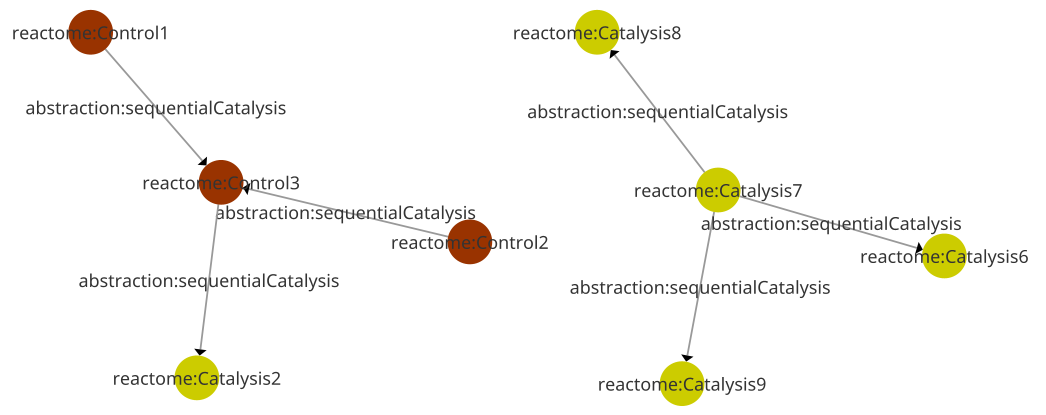

### Interacts With

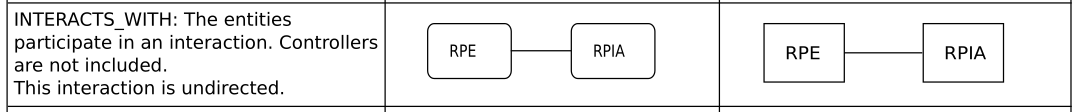

In [ ]:
query_interacts_with = """  
CONSTRUCT {
    ?participant1 abstraction:interactsWith ?participant2 .
}
WHERE {
    # Définition des rôles possibles des participants
    VALUES (?role1 ?role2) { 
        (bp3:left bp3:left)     # Liens entre participants gauche
        (bp3:right bp3:right)   # Liens entre participants droite
        (bp3:left bp3:right)    # Liens entre participants gauche et droite
    }
  VALUES ?interaction { <http://www.reactome.org/biopax/90/2173789#BiochemicalReaction40> }
    
    ?interaction rdf:type/(rdfs:subClassOf*) bp3:Interaction .
    ?interaction ?role1 ?participant1 .
    ?interaction ?role2 ?participant2 .
    
    # Évite de lier un participant avec lui-même
    FILTER(?participant1 != ?participant2)
    
    # Évite les doublons symétriques
    FILTER(STR(?participant1) > STR(?participant2))
}
"""

### Generic Of

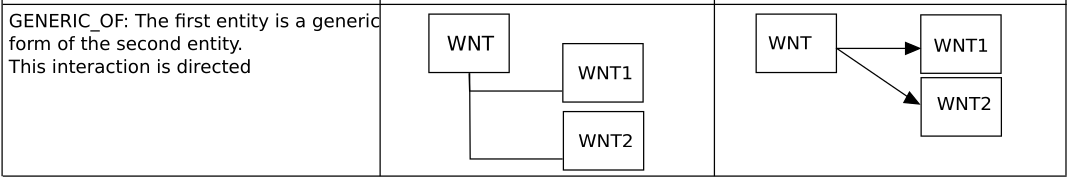

In [ ]:
query_generic_of = """  
CONSTRUCT {
  ?protRef abstraction:genericOf ?prot .
}
WHERE {
  ?prot rdf:type/(rdfs:subClassOf*) bp3:Protein .
  ?prot bp3:entityReference ?protRef .
  ?protRef rdf:type/(rdfs:subClassOf*) bp3:ProteinReference .
}

"""

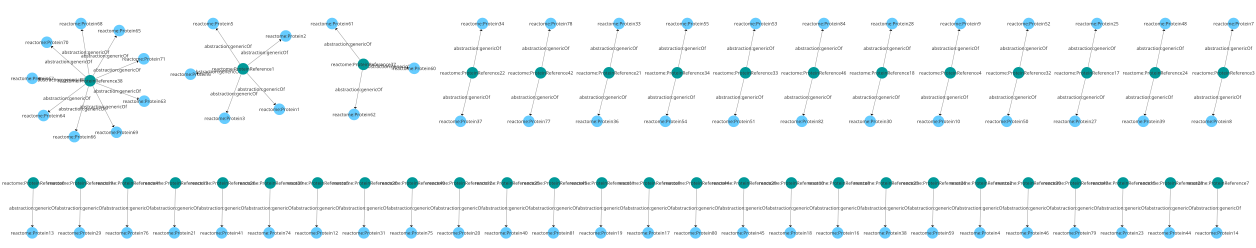

In [ ]:
"""
# Start the Fuseki server (adjust file paths and dataset name as needed)
command = [
    '/home/cbeust/Softwares/JenaFuseki/apache-jena-fuseki-4.9.0/fuseki-server',
    '--file', reactome_test_example,
    '--file', BioPAX_Ontology_file_path,
    '/reactome_tgf_smads'
]

process = subprocess.Popen(command)
time.sleep(60)  # Allow time for the server to start

# Set up the SPARQL endpoint and query
sparql = SPARQLWrapper(endpoint_test_example_reactome)
sparql.setQuery(prefixes + query_in_same_component)
sparql.setReturnFormat(XML)  # Request the result in RDF/XML format

# Execute the query and retrieve the result in RDF/XML
response = sparql.query().convert()  # 'response' is a bytes object in RDF/XML format

# Parse the RDF/XML response with rdflib
graph = Graph()
graph.parse(data=response, format="xml")

# Define the output file path and save the RDF data to a file
output_file_path = "../Results/ProteinView/proteinsInSameComponent.rdf"
graph.serialize(destination=output_file_path, format="xml")

# Print confirmation
print(f"RDF results saved to {output_file_path}")

# Terminate the Fuseki server process if necessary
process.terminate()
"""